In [1]:
# Cài các thư viện cần thiết:
# - transformers: để tải model pretrained (DistilBERT)
# - datasets: để load dữ liệu có sẵn (IMDb)
# - evaluate: để tính các chỉ số đánh giá (accuracy, F1,...)
!pip install transformers datasets evaluate -q



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Load dataset
# IMDb là bộ dữ liệu đánh giá phim gồm 2 lớp:
# positive review
# negative review

from datasets import load_dataset

dataset = load_dataset("imdb")

# Kiểm tra nhanh dữ liệu
print(dataset)
print(dataset["train"][0])


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and

In [3]:
# Load pretrained model & tokenizer
# Chúng ta dùng mô hình DistilBERT (phiên bản nhẹ của BERT)
# Tokenizer sẽ chuyển text thành token IDs (input cho model)

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [4]:
# Preprocess the dataset
# Chúng ta tokenize văn bản và padding/truncate để cùng độ dài (max_length=128)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Để huấn luyện nhanh hơn, ta chọn mẫu nhỏ hơn từ train/test
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))


Map: 100%|██████████| 50000/50000 [00:09<00:00, 5394.17 examples/s]


In [7]:
# Define training arguments (fixed for transformers new API)
# Các tham số huấn luyện gồm:
# - output_dir: thư mục lưu kết quả
# - evaluation_strategy: đánh giá sau mỗi epoch
# - learning_rate, batch size, số epoch...

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch", 
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)


In [8]:
# Create Trainer and fine-tune model
# Trainer sẽ tự động:
# - huấn luyện (train)
# - đánh giá (evaluate)
# - lưu kết quả (logs, metrics)

from transformers import Trainer
import evaluate
import numpy as np

# Define evaluation metric (accuracy)
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Load pretrained model cho 2 lớp (binary classification)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Bắt đầu fine-tune
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\chong\AppData\Local\Temp\ipykernel_15376\1769420428.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.427517,0.815000
2,No log,0.484144,0.806000
3,No log,0.606492,0.800000
4,0.272500,0.612266,0.829000
5,0.272500,0.745920,0.828000
6,0.272500,0.811864,0.826000
7,0.272500,0.908287,0.824000
8,0.046000,0.917275,0.828000
9,0.046000,0.920678,0.827000
10,0.046000,0.929716,0.826000


TrainOutput(global_step=1250, training_loss=0.13019683589935302, metrics={'train_runtime': 251.3752, 'train_samples_per_second': 79.562, 'train_steps_per_second': 4.973, 'total_flos': 662336993280000.0, 'train_loss': 0.13019683589935302, 'epoch': 10.0})

In [9]:
# Evaluate the model
# Sau khi huấn luyện xong, ta đánh giá độ chính xác trên tập test

eval_result = trainer.evaluate()
print("Evaluation result:", eval_result)


Evaluation result: {'eval_loss': 0.9297159910202026, 'eval_accuracy': 0.826, 'eval_runtime': 3.291, 'eval_samples_per_second': 303.856, 'eval_steps_per_second': 19.143, 'epoch': 10.0}


In [13]:
# Thử mô hình với ví dụ mới
# Dự đoán cảm xúc của câu "I love this movie!"

test_sentence = "I love this movie! It was fantastic."
inputs = tokenizer(test_sentence, return_tensors="pt").to(model.device)

outputs = model(**inputs)
pred = outputs.logits.argmax(-1).item()

print("Sentence:", test_sentence)
print("Predicted label:", "Positive " if pred == 1 else "Negative ")


Sentence: I love this movie! It was fantastic.
Predicted label: Positive 


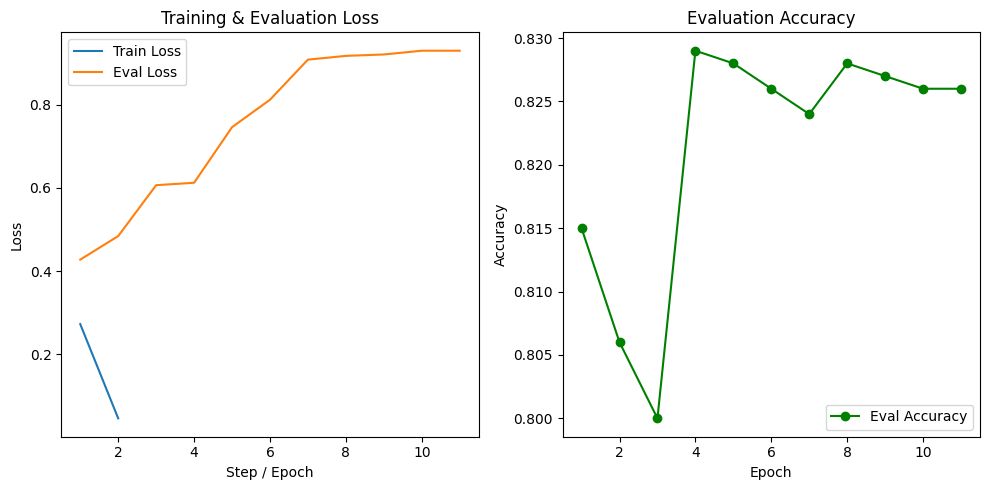

In [14]:
# Visualize training results
# Sau khi huấn luyện, Trainer lưu log loss / metric trong trainer.state.log_history
# Trực quan hóa tiến trình huấn luyện qua các epoch.

import matplotlib.pyplot as plt

# Lấy log lịch sử huấn luyện
logs = trainer.state.log_history

train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
eval_acc  = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
epochs = list(range(1, len(eval_loss)+1))

plt.figure(figsize=(10,5))

# Biểu đồ training & validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss)+1), train_loss, label="Train Loss")
plt.plot(epochs, eval_loss, label="Eval Loss")
plt.xlabel("Step / Epoch")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()

# Biểu đồ accuracy theo epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, marker='o', color='green', label="Eval Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
